In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import matplotlib.dates as mdates
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

# Setup logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [2]:
def load_data():
    logger.info("Loading datasets...")
    train = pd.read_csv('../data/train.csv', low_memory=False)
    test = pd.read_csv('../data/test.csv', low_memory=False)
    store = pd.read_csv('../data/store.csv', low_memory=False)
    logger.info(f"Train dataset shape: {train.shape}")
    logger.info(f"Test dataset shape: {test.shape}")
    logger.info(f"Store dataset shape: {store.shape}")
    return train, test, store

train, test, store = load_data()

2024-07-17 16:31:49,196 - INFO - Loading datasets...
2024-07-17 16:31:50,897 - INFO - Train dataset shape: (1017209, 9)
2024-07-17 16:31:50,898 - INFO - Test dataset shape: (41088, 8)
2024-07-17 16:31:50,899 - INFO - Store dataset shape: (1115, 10)


In [3]:
def inspect_data(train, test, store):
    logger.info(f"Store dataset columns: {store.columns}")
    logger.info(f"Train dataset columns: {train.columns}")
    logger.info(f"Test dataset columns: {test.columns}")

inspect_data(train, test, store)

2024-07-17 16:32:40,447 - INFO - Store dataset columns: Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
2024-07-17 16:32:40,448 - INFO - Train dataset columns: Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')
2024-07-17 16:32:40,449 - INFO - Test dataset columns: Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')


In [4]:
def merge_data(train, test, store):
    logger.info("Merging datasets...")
    train_merged = pd.merge(train, store, on='Store', how='left')
    test_merged = pd.merge(test, store, on='Store', how='left')
    logger.info("Removing duplicates...")
    train_merged.drop_duplicates(inplace=True)
    test_merged.drop_duplicates(inplace=True)
    return train_merged, test_merged

train_merged, test_merged = merge_data(train, test, store)

2024-07-17 16:33:14,668 - INFO - Merging datasets...
2024-07-17 16:33:14,943 - INFO - Removing duplicates...


In [5]:
def handle_missing_values(train_merged, test_merged, store):
    logger.info("Handling missing values in store dataset...")
    store.fillna({
        'CompetitionDistance': 0,
        'CompetitionOpenSinceMonth': 0,
        'CompetitionOpenSinceYear': 0,
        'Promo2SinceWeek': 0,
        'Promo2SinceYear': 0,
        'PromoInterval': 0
    }, inplace=True)

    logger.info("Handling missing values in train and test datasets...")
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']:
        train_merged[col].fillna(0, inplace=True)
        test_merged[col].fillna(0, inplace=True)

    test_merged['Open'].fillna(1, inplace=True)

    logger.info(f"Remaining missing values in the train dataset:\n{train_merged.isnull().sum()}")
    logger.info(f"Remaining missing values in the test dataset:\n{test_merged.isnull().sum()}")
    logger.info(f"Remaining missing values in the store dataset:\n{store.isnull().sum()}")

handle_missing_values(train_merged, test_merged, store)

2024-07-17 16:33:37,438 - INFO - Handling missing values in store dataset...
2024-07-17 16:33:37,443 - INFO - Handling missing values in train and test datasets...
2024-07-17 16:33:37,666 - INFO - Remaining missing values in the train dataset:
Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64
2024-07-17 16:33:37,686 - INFO - Remaining missing values in the test dataset:
Id                           0
Store                        0
DayOfWeek                    0
Date         

In [6]:
def plot_distribution(data, column, title):
    plt.figure(figsize=(14, 6))
    sns.countplot(x=column, data=data)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

def plot_sales_behavior(data):
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='StateHoliday', y='Sales', data=data)
    plt.title('Sales Before, During, and After Holidays')
    plt.xlabel('StateHoliday')
    plt.ylabel('Sales')
    plt.show()

    data['HolidayType'] = data['StateHoliday'].replace({'0': 'None', 'a': 'Public Holiday', 'b': 'Easter Holiday', 'c': 'Christmas'})
    data['Date'] = pd.to_datetime(data['Date'])

    downsampled_data = data.sample(frac=0.1, random_state=42) if len(data) > 20000 else data

    plt.figure(figsize=(18, 8))
    sns.lineplot(x='Date', y='Sales', data=downsampled_data, errorbar=None)
    holidays = downsampled_data[downsampled_data['HolidayType'] != 'None']
    for holiday_type, holiday_group in holidays.groupby('HolidayType'):
        plt.scatter(holiday_group['Date'], holiday_group['Sales'], label=holiday_type, s=50, alpha=0.7)

    plt.title('Sales Trend with Holiday Annotations')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.legend(title='Holiday Type')
    plt.tight_layout()
    plt.show()

def plot_seasonal_behavior(data):
    data['Month'] = pd.to_datetime(data['Date']).dt.month
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Month', y='Sales', data=data)
    plt.title('Sales by Month')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.show()

def plot_correlation(data):
    correlation = data[['Sales', 'Customers']].corr()
    logger.info(f"Correlation between Sales and Customers:\n{correlation}")

    plt.figure(figsize=(14, 6))
    sns.scatterplot(x='Customers', y='Sales', data=data)
    plt.title('Sales vs. Customers')
    plt.xlabel('Customers')
    plt.ylabel('Sales')
    plt.show()

def plot_promos(data):
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Promo', y='Sales', data=data)
    plt.title('Sales During and Without Promotions')
    plt.xlabel('Promo')
    plt.ylabel('Sales')
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Promo', y='Customers', data=data)
    plt.title('Customers During and Without Promotions')
    plt.xlabel('Promo')
    plt.ylabel('Customers')
    plt.show()

def plot_opening_hours(data):
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Open', y='Customers', data=data)
    plt.title('Customer Count During Open and Close Times')
    plt.xlabel('Open')
    plt.ylabel('Customers')
    plt.show()

def plot_assortment(data):
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Assortment', y='Sales', data=data)
    plt.title('Sales by Assortment Type')
    plt.xlabel('Assortment')
    plt.ylabel('Sales')
    plt.show()

def plot_competition(data):
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x='CompetitionDistance', y='Sales', data=data)
    plt.title('Sales vs. Competition Distance')
    plt.xlabel('CompetitionDistance')
    plt.ylabel('Sales')
    plt.show()

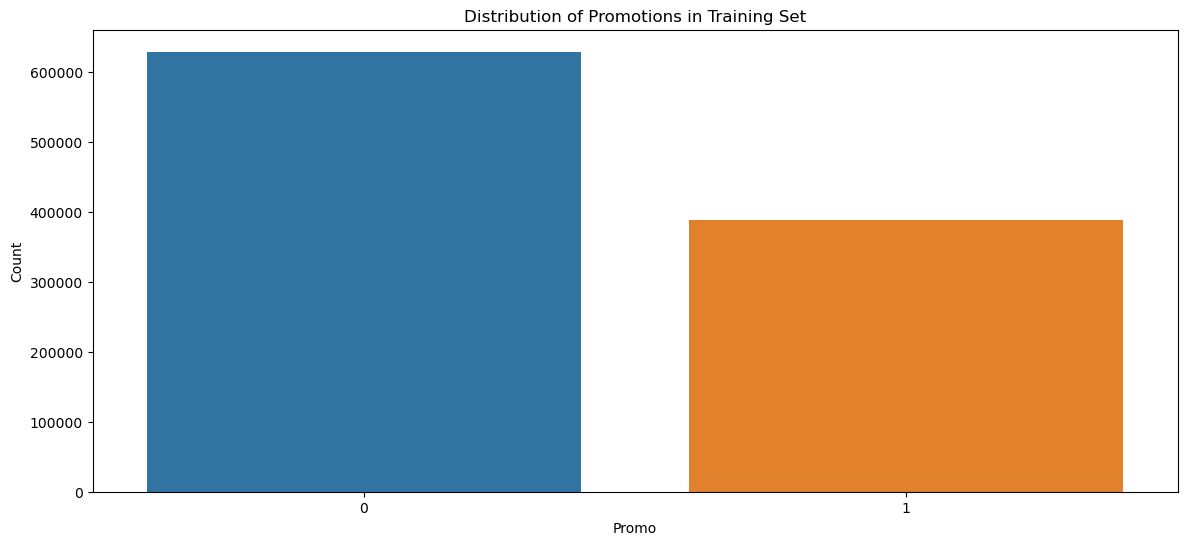

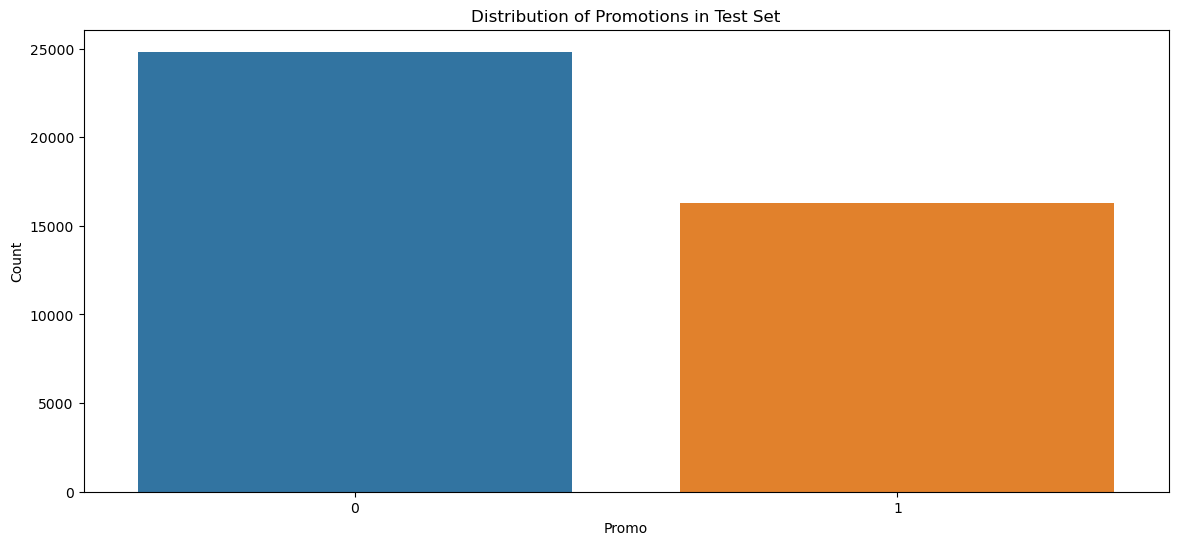

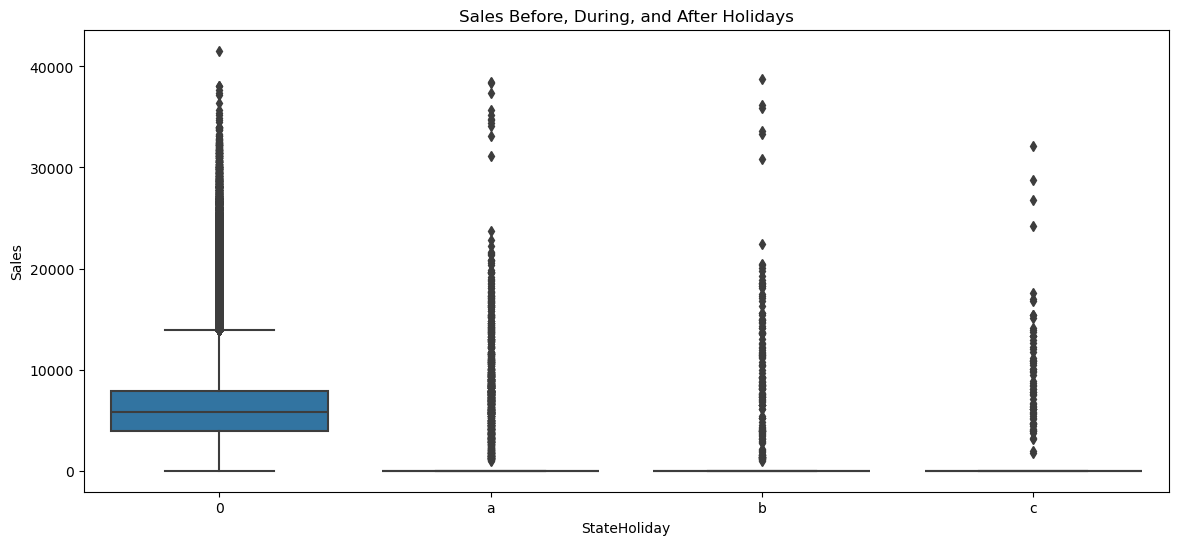

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


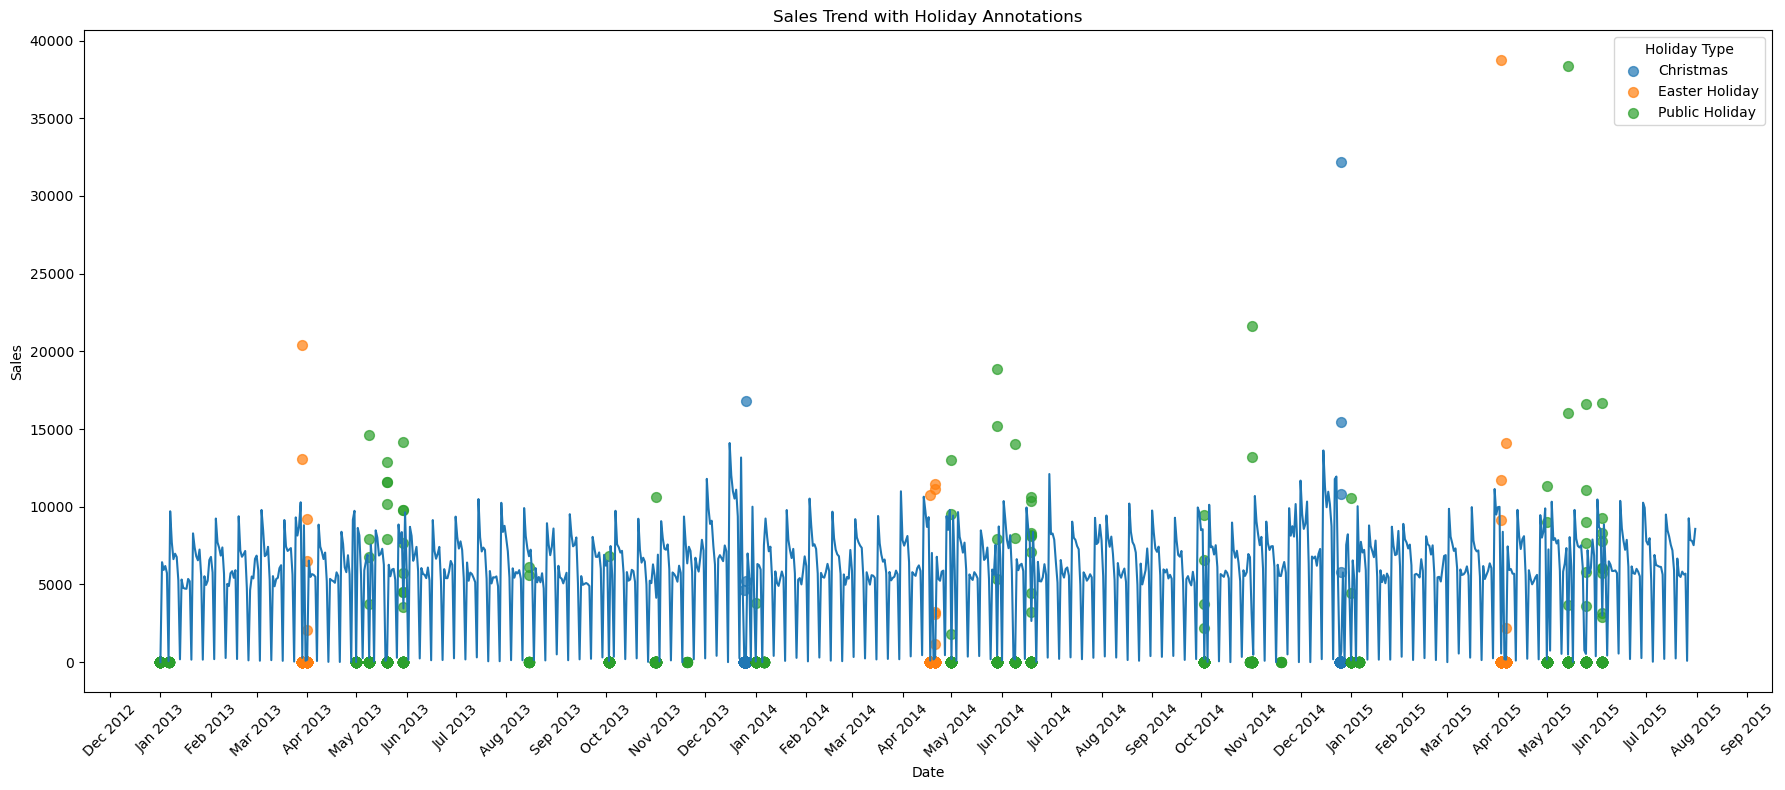

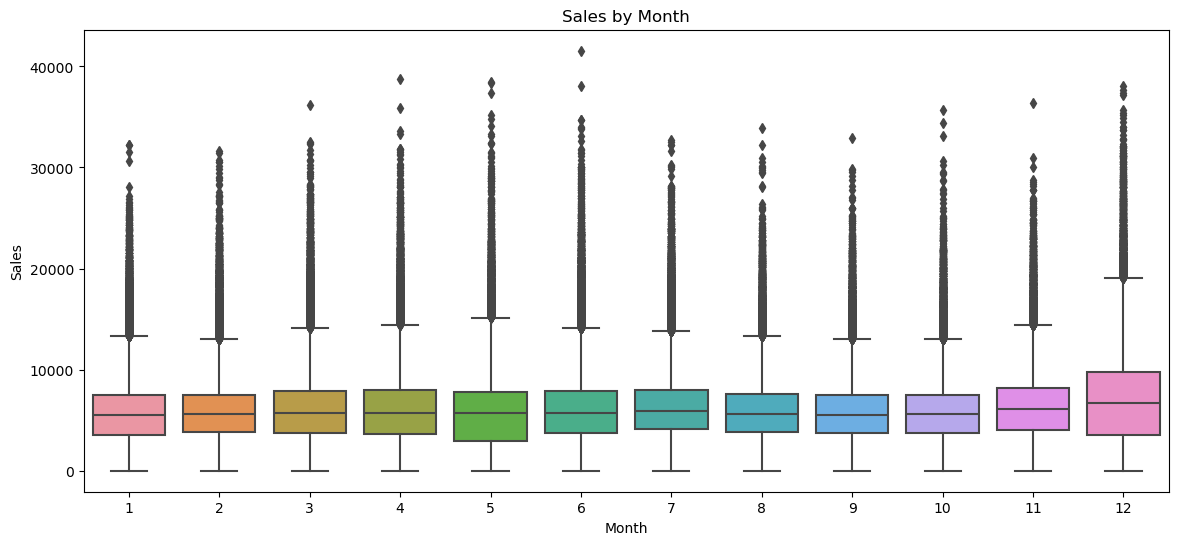

2024-07-17 16:34:43,885 - INFO - Correlation between Sales and Customers:
              Sales  Customers
Sales      1.000000   0.894711
Customers  0.894711   1.000000


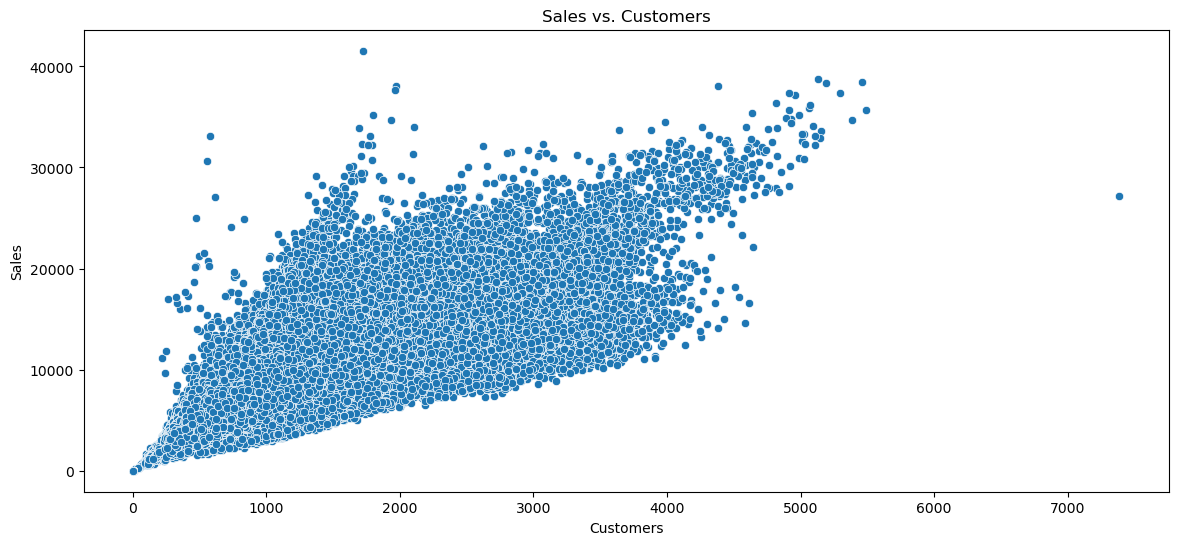

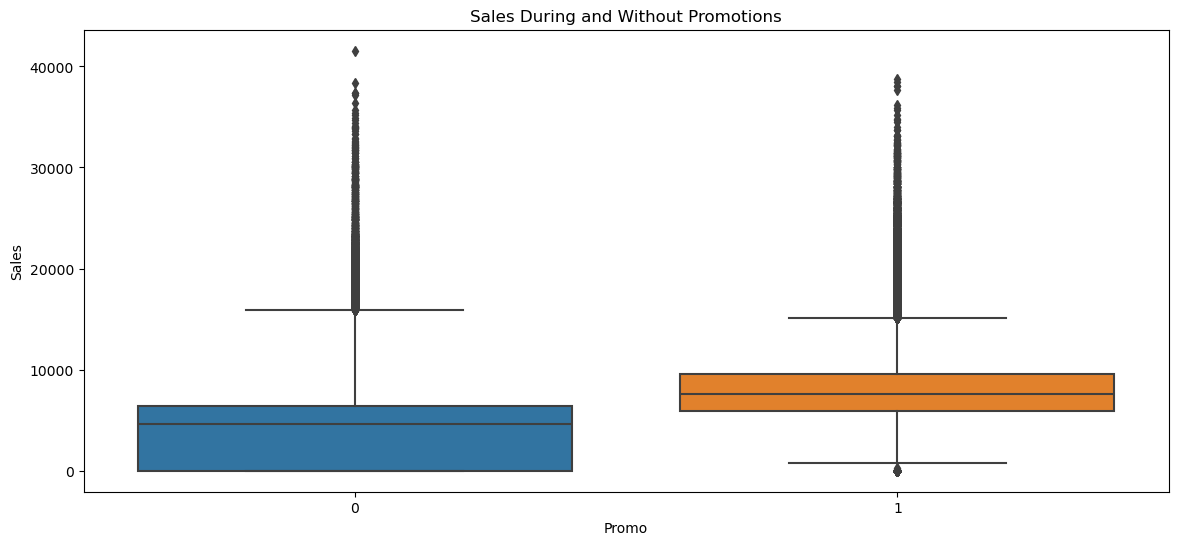

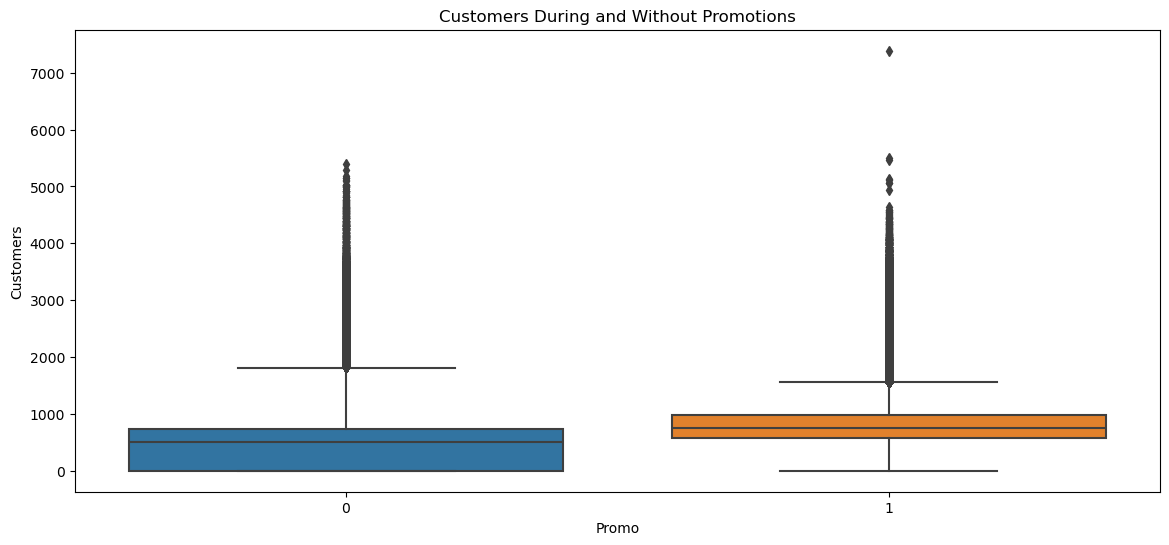

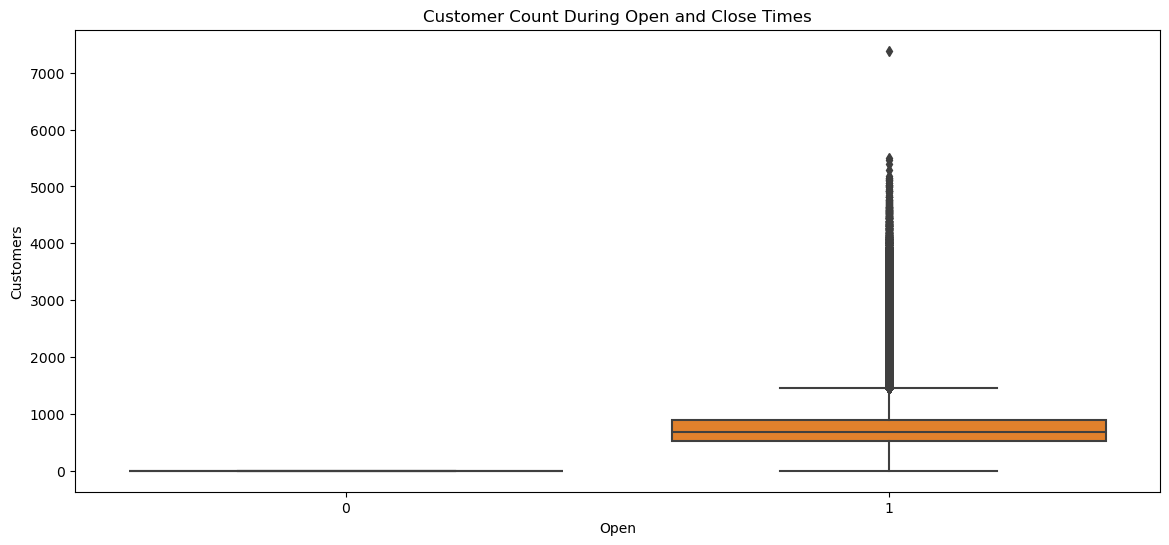

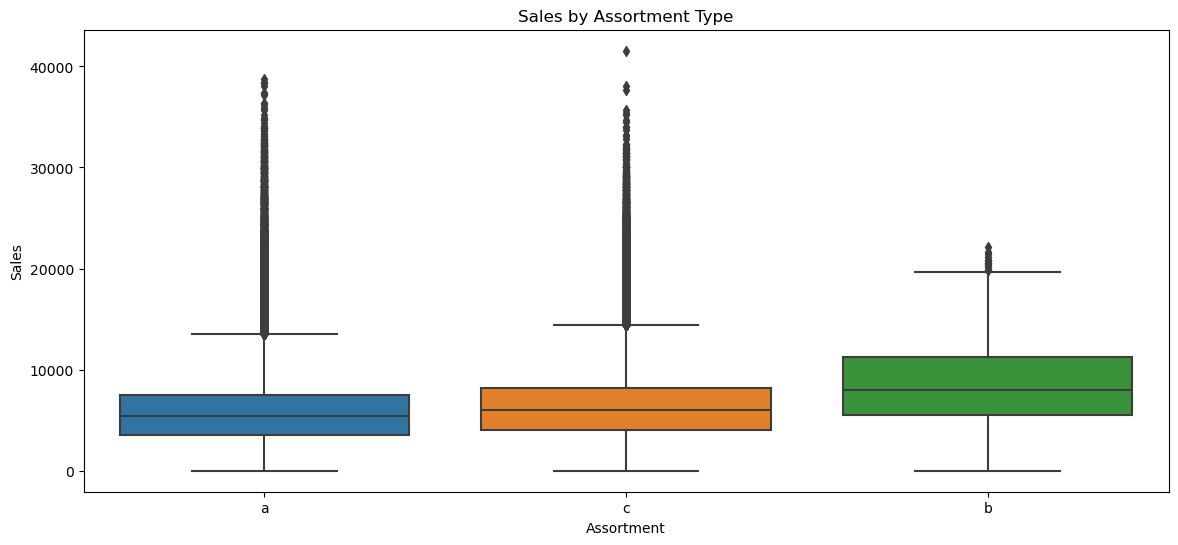

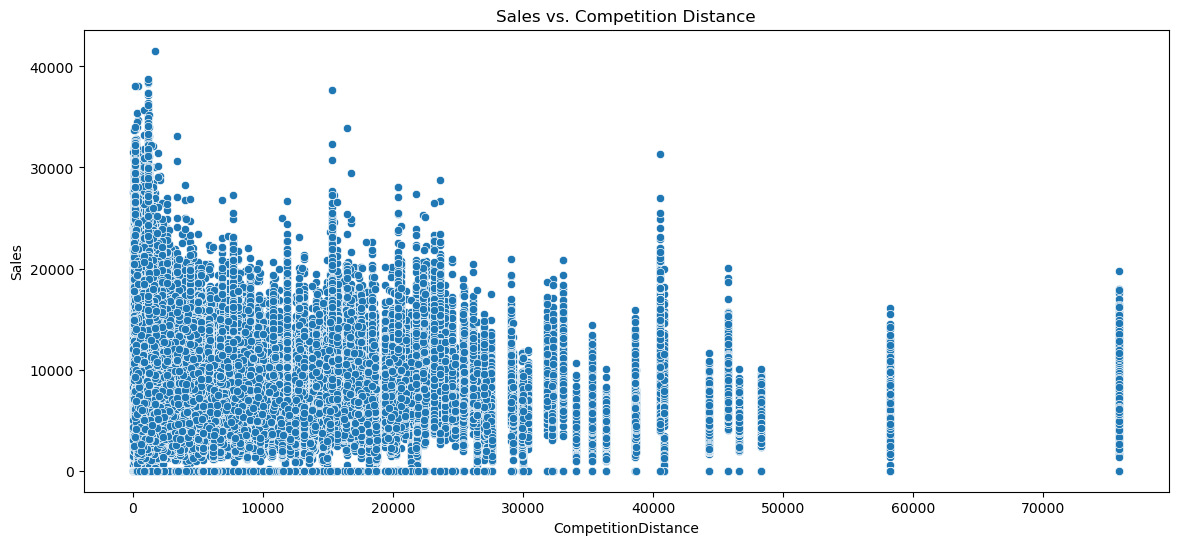

In [7]:
plot_distribution(train_merged, 'Promo', 'Distribution of Promotions in Training Set')
plot_distribution(test_merged, 'Promo', 'Distribution of Promotions in Test Set')
plot_sales_behavior(train_merged)
plot_seasonal_behavior(train_merged)
plot_correlation(train_merged)
plot_promos(train_merged)
plot_opening_hours(train_merged)
plot_assortment(train_merged)
plot_competition(train_merged)

In [8]:
def save_cleaned_data(train_data, test_data):
    train_data.to_csv('../outputs/train_cleaned.csv', index=False)
    test_data.to_csv('../outputs/test_cleaned.csv', index=False)
    logger.info("Cleaned datasets saved.")

save_cleaned_data(train_merged, test_merged)

2024-07-17 16:35:51,876 - INFO - Cleaned datasets saved.


In [11]:
train_cleaned = pd.read_csv('../outputs/train_cleaned.csv', low_memory=False)
train_cleaned['Date'] = pd.to_datetime(train_cleaned['Date'])


C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


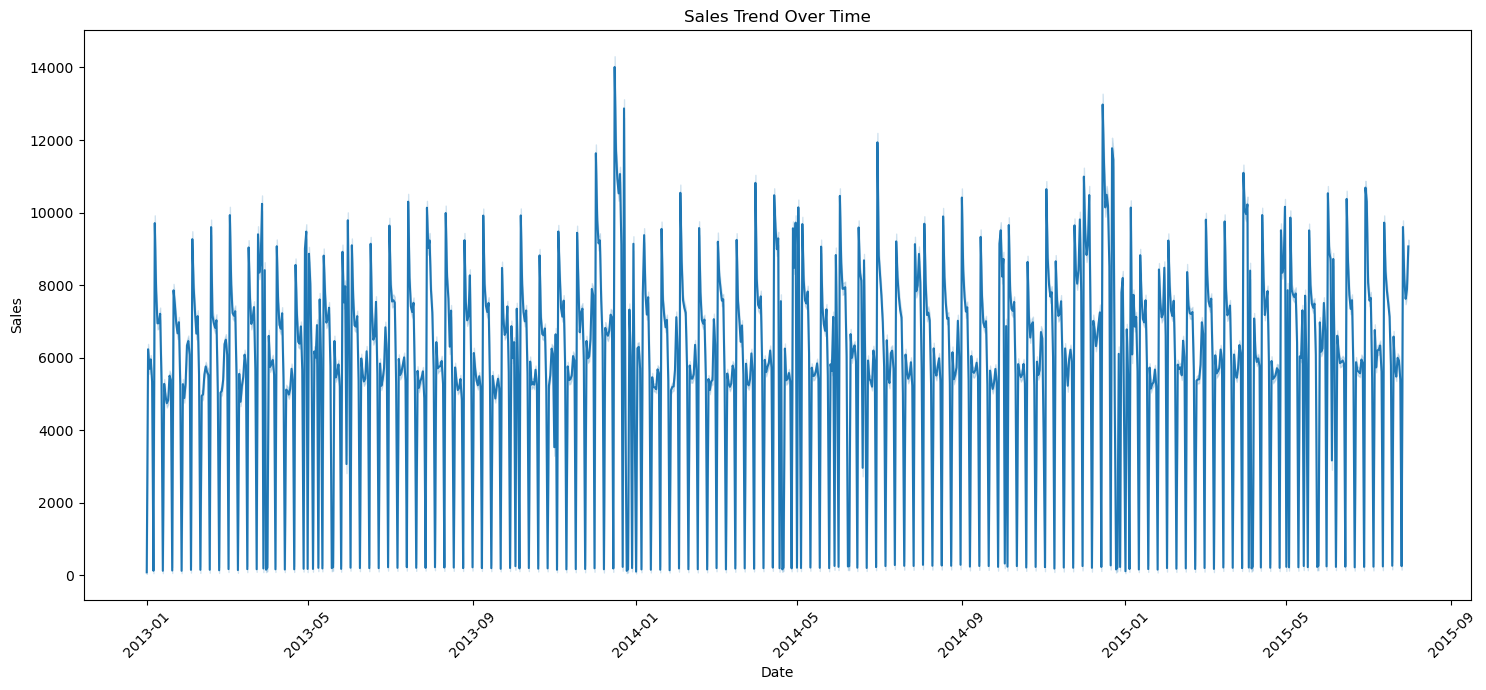

In [12]:
def plot_sales_trend(data):
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=data, x='Date', y='Sales')
    plt.title('Sales Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_sales_trend(train_cleaned)

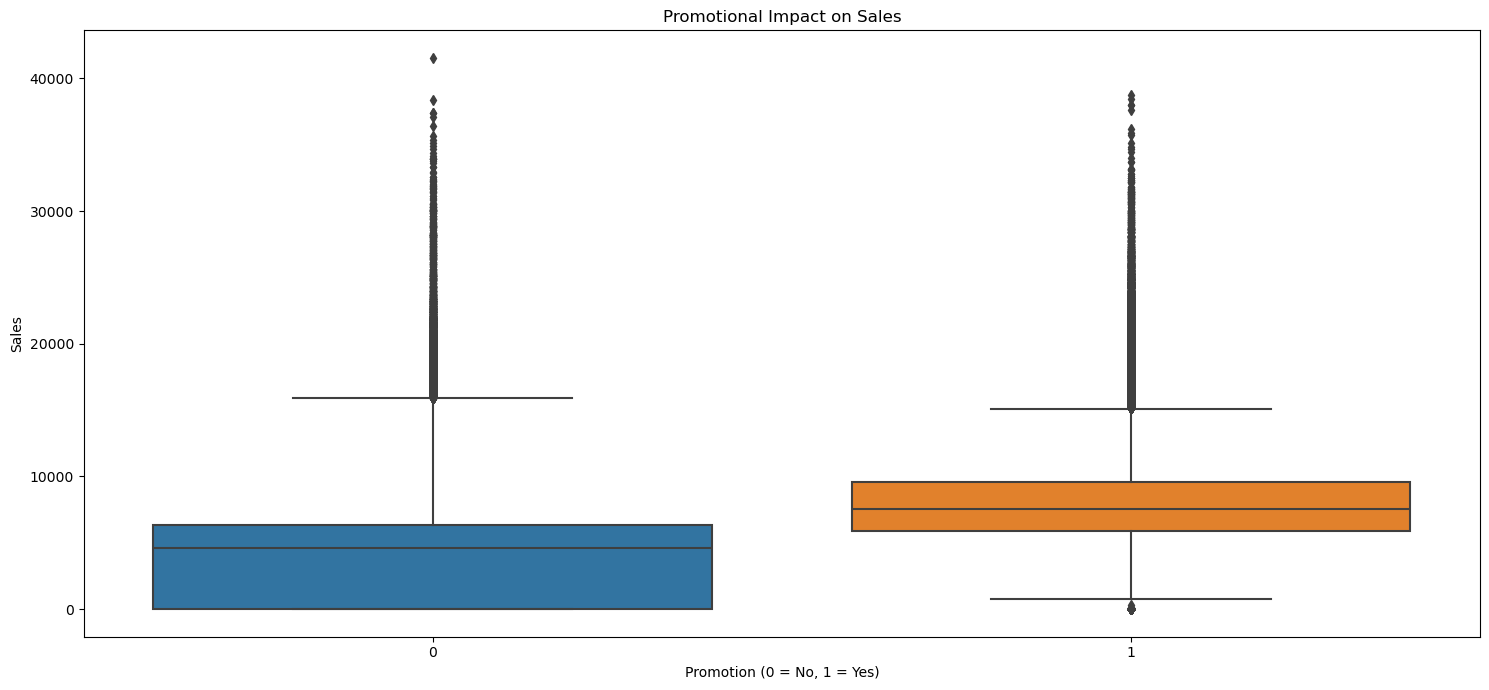

In [13]:
def plot_promo_impact(data):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=data, x='Promo', y='Sales')
    plt.title('Promotional Impact on Sales')
    plt.xlabel('Promotion (0 = No, 1 = Yes)')
    plt.ylabel('Sales')
    plt.tight_layout()
    plt.show()

plot_promo_impact(train_cleaned)

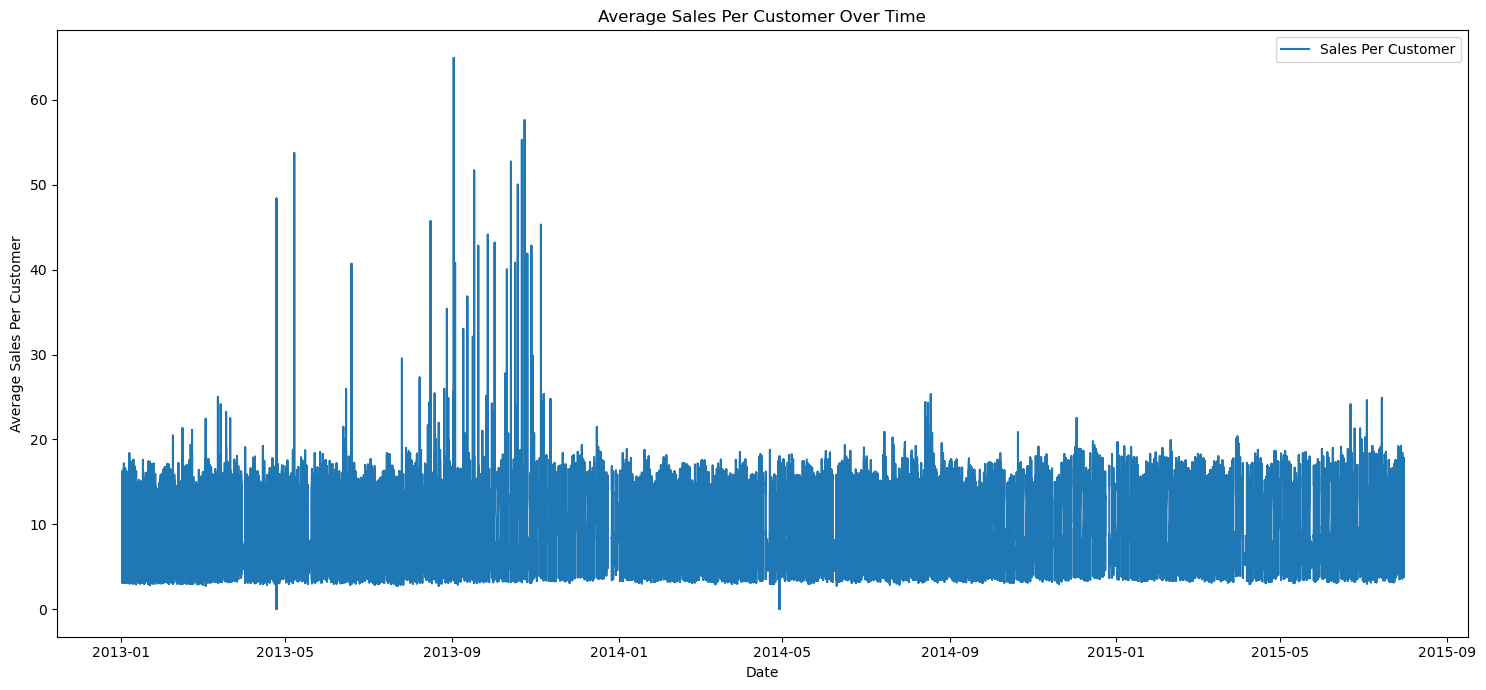

In [14]:
def plot_sales_per_customer(data):
    data['SalesPerCustomer'] = data['Sales'] / data['Customers']
    plt.figure(figsize=(15, 7))
    plt.plot(data['Date'], data['SalesPerCustomer'], label='Sales Per Customer')
    plt.title('Average Sales Per Customer Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Sales Per Customer')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_sales_per_customer(train_cleaned)